# Introduction
This notebook is about data science solutions for separating ham and spam mails.

### Workflow stages
The solution workflow goes through eight stages described in the Data Science Solutions book.

1. Problem Statement.
2. Data Gathering & Initial Preprocessing.
3. Analyze, identify patterns, and explore the data.
4. Wrangling, preparation, cleansing the data.
5. Model Selection, Training and Optimisation.
6. Model Evaluation.
7. Model Testing.
8. Model Exportation for Production.

The workflow indicates general sequence of how each stage may follow the other. However there are use cases with exceptions.


# Problem Statement
The problem is to find out which is spam mail and which is ham mail.

In [ ]:
# installation of important libraries 
# (make sure you install these libraies else you will get error in importation)
!pip install langdetect
!pip install googletrans==3.1.0a0
!pip install collections
!pip install wordcloud
!pip install contractions
!pip install autocorrect
!pip install unidecode
!pip install rake_nltk
!pip install yake
!pip install gensim
!pip install yellowbrick
!pip install imblearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 KB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=4186b0fea06992a8a3e435e2a82cf45bd95ae1571f7f567fae1901a63fd44989
  Stored in directory: /root/.cache/pip/wheels/d1/c1/d9/7e068de779d863bc8f8fc9467d85e25cfe47fa5051fff1a1bb
Successfully built langdetect
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 KB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 KB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

In [ ]:
# importing libraries
# for language detection
from langdetect import detect

# for language translation
from googletrans import Translator

# to get counts and most common elements
from collections import Counter

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# to get wordcloud
from wordcloud import WordCloud

# to fetch ngrams
from nltk.util import ngrams

# to ignore warnings
import warnings
warnings.filterwarnings('ignore')

# for data analysis and manipulation
import pandas as pd
import numpy as np

# to expand the text (don't to do not)
import contractions

# to auto correct the words
from autocorrect import Speller

# for handling accented characters (Á to A)
from unidecode import unidecode

# to get list of punctuations
from string import punctuation

# nltk libraries 
from nltk.tokenize import word_tokenize # to make tokens (sentense/words)
from nltk.corpus import stopwords # to get list of stopwords
from nltk.stem import WordNetLemmatizer # to find root words

# for extracting the keywords
import yake
from rake_nltk import Rake

# for making vectors of the documents
from gensim.models import Word2Vec, keyedvectors

# to see how the clusters are generated
from yellowbrick.cluster import SilhouetteVisualizer

# scikit_learn libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from xgboost import XGBClassifier

# to balance the data
from imblearn.over_sampling import SMOTE

# Data Gathering

In [ ]:
path = "spam.csv"
df = pd.read_csv(path,encoding = "ISO-8859-1")
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


#### Data Information
we have the data, including v1,v2,Unnamed:2, etc coloumns. 
    
    v1: has the information about ham or spam (Target Variable)
    
    v2: has the text of the mails.
    rest are empty. 
    
**So I will take only two columns (v1 and v2), and rename them according to my needs. After that, I will detect the languages and translate them in only english**

### Initial Preprocessing

In [ ]:
# renaming the columns
df = df[["v1","v2"]]
df.rename({"v1": "target","v2":"text"},axis = 1,inplace=True)
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# Defining the function to detect languages
# If we have empty string so langdetect will give error. So, I am using try except.
def lang_detect(data):
    m = ""
    try:
        m = detect(data)
    except:
        pass
    return m
s = pd.Series(df["text"].apply(lang_detect))
s.unique()

array(['en', 'id', 'fr', 'so', 'af', 'it', 'ca', 'da', 'cy', 'sk', 'sl',
       'sv', 'nl', 'tl', 'es', 'vi', 'no', 'de', 'sq', 'et', 'pt', 'sw',
       'pl', 'hr', '', 'ro', 'tr', 'cs', 'lt', 'fi'], dtype=object)

In [ ]:
#defining the function for translation
def lang_translate(data):
    translor = Translator()
    tr_text = translor.translate(data,dest="en")
    return tr_text.text
df["mail"] = df["text"].apply(lang_translate)
df.head()

,target,text,mail
0,ham,"Go until jurong point, crazy.. Available only ...","Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro...","Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# As we know translator takes high time to translate.
# So I am exporting this file for further use.
df.to_csv("translated_mail.csv",index = False)

In [ ]:
# dropping the text features as we have new features mail with translated mails
df.drop("text",axis = 1, inplace = True)

# EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  5572 non-null   object
 1   mail    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [ ]:
df.isna().sum()

target    0
mail      0
dtype: int64

**No null values found**

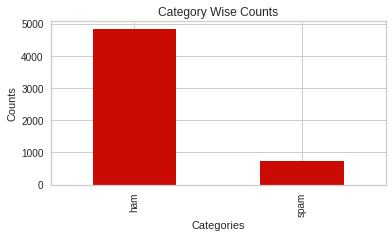

In [ ]:
_ = df.target.value_counts()
plt.figure(figsize = (6,3))
_.plot(kind = "bar",color = "r")
plt.ylabel("Counts")
plt.xlabel("Categories")
plt.title("Category Wise Counts")
plt.show()

**Here we can see that, Data is highly imbalanced**

### Checking Ngrams

In [ ]:
# defining function to get ngrams
def get_ngrams(data, n_range):
    tokens = data.split()
    ngrms  = ngrams(tokens, n_range ) # provide zip file
    ngrms_lst = []
    for i in ngrms: #unzipping the file
        ngrms_lst.append(" ".join(i))
    return ngrms_lst

In [ ]:
# getting unigrams
unigrams = df.mail.apply(lambda x: get_ngrams(x,1))
unigrams.head(10)

0    [Go, until, jurong, point,, crazy.., Available...
1                 [Ok, lar..., Joking, wif, u, oni...]
2    [Free, entry, in, 2, a, wkly, comp, to, win, F...
3    [U, dun, say, so, early, hor..., U, c, already...
4    [Nah, I, don't, think, he, goes, to, usf,, he,...
5    [FreeMsg, Hey, there, darling, it's, been, 3, ...
6    [Even, my, brother, is, not, like, to, speak, ...
7    [As, per, your, request, 'Melle, Melle, (Oru, ...
8    [WINNER!!, As, a, valued, network, customer, y...
9    [Had, your, mobile, 11, months, or, more?, U, ...
Name: mail, dtype: object

In [ ]:
# checking most repeated words from all the mails
lst = []
for i in unigrams:
    lst.extend(i)
Counter(lst).most_common(10)

[('to', 2146),
 ('you', 1636),
 ('I', 1469),
 ('a', 1331),
 ('the', 1214),
 ('and', 893),
 ('in', 800),
 ('is', 784),
 ('i', 742),
 ('u', 682)]

In [ ]:
# cheking most repeted 10 trigrams
trigram = df.mail.apply(lambda x: get_ngrams(x,3))
lst1 = []
for i in trigram:
    lst1.extend(i)
Counter(lst1).most_common(10)

[("I'll call later", 39),
 ("Sorry, I'll call", 38),
 ('. . .', 26),
 ('I want to', 24),
 ('have won a', 23),
 ('prize GUARANTEED. Call', 19),
 ('I miss you', 19),
 ('å£1000 cash or', 17),
 ('are trying to', 16),
 ('Account Statement for', 16)]

### Plotting Word Cloud

In [ ]:
def get_wordcloud(data,column):
    df_ = data[column].str.cat(sep = " ")
    text = " ".join([i for i in df_.split()])
    wcloud = WordCloud(width = 700, height = 500, background_color = "lightgreen").generate(text)
    plt.figure(figsize = (10,6))
    plt.imshow(wcloud)
    plt.axis("off")
    plt.title("Word Cloud")
    plt.show()

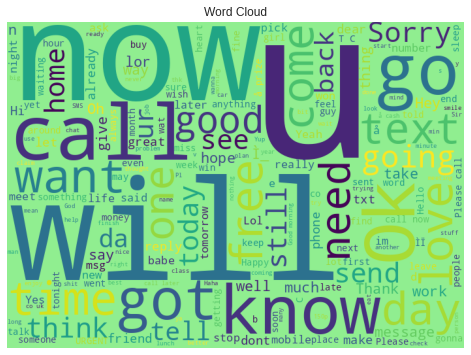

In [ ]:
#plotting word cloud
get_wordcloud(df,"mail")

### Keyphrase Extrection

In [ ]:
# Defining the function to extract keywords
def get_keypharses(data):
    key_ex = yake.KeywordExtractor()
    keyword = key_ex.extract_keywords(data) # give (kewword, score) in a tuple
    kw_lst = []
    for i in keyword:
        kw_lst.append(i[0]) # taking only keyword
    return kw_lst

In [ ]:
kw = df.mail.apply(get_keypharses)
kw.head(10)

0    [crazy., jurong point, point, jurong, buffet, ...
1       [lar, Joking wif, wif u oni, Joking, oni, wif]
2    [Cup final tkts, win FA Cup, Cup final, final ...
3                         [early hor, hor, dun, early]
4                                    [Nah, usf, lives]
5    [FreeMsg Hey, Hey there darling, word back, He...
6    [aids patent, brother, speak, patent, treat, a...
7    [Oru Minnaminunginte Nurungu, Minnaminunginte ...
8    [WINNER, prize reward, claim, Valid, prize, re...
9    [Update, Mobile Update, months, Free, mobile, ...
Name: mail, dtype: object

In [ ]:
# cheking most common keywords
lstk = []
for i in kw:
    lstk.extend(i)
Counter([i for i in lstk if len(i.split()) > 2]).most_common(10)

[('selected to receive', 13),
 ('attempt to contact', 13),
 ('pick the phone', 12),
 ('send a message', 12),
 ('customer service representative', 10),
 ('WON a guaranteed', 10),
 ('call our customer', 10),
 ('draw txt MUSIC', 9),
 ('chance to win', 9),
 ('anytime any network', 9)]

# Preprocessing 

In [ ]:
# Cleaning the data
import nltk
nltk.download('stopwords')

def remove_spaces(data):
    clean_text = data.replace("\\n"," ").replace("\t"," ").replace("\\"," ")
    return clean_text

# defining the function for expanding text (can't to can not)
def expand_text(data):
    ex_text = contractions.fix(data)
    return ex_text

# defining the function for handling accented characters (Á to A)
def handling_accented(data):
    fix_text = unidecode(data)
    return fix_text

# defining the function for removing stopwords
stopword = stopwords.words("english") # gives a list of stopwords
stopword.remove("no") # removing neccessary stop words from list
stopword.remove("not")
stopword.remove("nor")

def clean_text(data):
    token = word_tokenize(data)
    clean_text = [i.lower() for i in token if (i not in punctuation) 
                  and (i.lower() not in stopword) and (i.isalpha()) and (len(i) > 2)]
    return clean_text

# defining the function for auto correction 


def auto_correct(data):
    spell = Speller(lang = "en")
    text = spell(data)
    return text

# defining the function for getting root words
def lemmatization(data):
    lem = WordNetLemmatizer()
    lst1 = []
    for i in data:
        lem_words = lem.lemmatize(i)
        lst1.append(lem_words)
    return " ".join(lst1)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

df["clean_mails"] = df["mail"].apply(remove_spaces)
df["clean_mails"] = df["clean_mails"].apply(expand_text)
df["clean_mails"] = df["clean_mails"].apply(handling_accented)
df["clean_mails"] = df["clean_mails"].apply(clean_text)
df["clean_mails"] = df["clean_mails"].apply(lambda x: auto_correct(x) if isinstance(x, str) or isinstance(x, bytes) else x)
df["clean_mails"] = df["clean_mails"].apply(lemmatization)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# Now we have final mails so we will drop the mail feature
df.drop("mail",axis = 1, inplace = True)
df.head(2)

,target,clean_mails
0,ham,jurong point crazy available bugis great world...
1,ham,lar joking wif oni


In [ ]:
# encoding the target feature
df.target.replace({"spam": 0, "ham": 1}, inplace=True)

### Making Vactors

In [ ]:
# spliting the data to avoid data leakage
x = df["clean_mails"]
y = df["target"]
x_tr,x_te,y_tr,y_te = train_test_split(x,y,test_size=0.25,random_state=42,stratify=y)

In [ ]:
# Creating the vectors of the mails
cnv = CountVectorizer(max_df=0.95,max_features=1000,min_df = 10, stop_words="english",lowercase=True)
x_train = cnv.fit_transform(x_tr).A
x_test  = cnv.transform(x_te).A

### Balancing The Data

In [ ]:
# I am using SMOTE to avoid data duplicacy
st = SMOTE(sampling_strategy=0.75,random_state=42)
sm_x_train,sm_y_train = st.fit_resample(x_train,y_tr)
sm_x_test,sm_y_test   = st.fit_resample(x_test,y_te)

In [ ]:
print(f"first we have\n{y_tr.value_counts()}\nAfter balancing we have\n{sm_y_train.value_counts()}")

first we have
1    3619
0     560
Name: target, dtype: int64
After balancing we have
1    3619
0    2714
Name: target, dtype: int64


# Model Selection & Training

In [ ]:
# selecting the model
models = [("Multinomial Naive Bayes", MultinomialNB()),
          ("Gaussian Naive Bayes", GaussianNB()),
          ("XG Boost", XGBClassifier())]
for name,model in models:
    mod = model
    mod.fit(sm_x_train,sm_y_train)
    pred = mod.predict(sm_x_train)
    acc = accuracy_score(sm_y_train,pred)
    pred1 = mod.predict(sm_x_test)
    acc1 = accuracy_score(sm_y_test,pred1)
    print(f"The accuracy of the {name} model:\nAt Training: ",acc)
    print("At Testing: ",acc1)
    print("+"*50)

The accuracy of the Multinomial Naive Bayes model:
At Training:  0.8885204484446549
At Testing:  0.819431279620853
++++++++++++++++++++++++++++++++++++++++++++++++++
The accuracy of the Gaussian Naive Bayes model:
At Training:  0.8128848886783515
At Testing:  0.7838862559241706
++++++++++++++++++++++++++++++++++++++++++++++++++
The accuracy of the XG Boost model:
At Training:  0.8965735038686247
At Testing:  0.8028436018957346
++++++++++++++++++++++++++++++++++++++++++++++++++


### Tuning & Training the model

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
estimator = MultinomialNB()
params_NB = {'alpha': [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000],
            "fit_prior":[True,False]} 
rnd = RandomizedSearchCV(estimator=estimator, param_distributions=params_NB,
                         cv= 3, verbose=3, scoring='accuracy',return_train_score=True) 
rnd.fit(sm_x_train,sm_y_train)
rnd.best_params_
#increase the CV to 7 when training on a high powered gpu else it will take high time

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END alpha=1000, fit_prior=True;, score=(train=0.737, test=0.793) total time=   0.0s
[CV 2/3] END alpha=1000, fit_prior=True;, score=(train=0.790, test=0.748) total time=   0.0s
[CV 3/3] END alpha=1000, fit_prior=True;, score=(train=0.786, test=0.760) total time=   0.0s
[CV 1/3] END alpha=0.1, fit_prior=False;, score=(train=0.928, test=0.896) total time=   0.0s
[CV 2/3] END alpha=0.1, fit_prior=False;, score=(train=0.922, test=0.923) total time=   0.0s
[CV 3/3] END alpha=0.1, fit_prior=False;, score=(train=0.922, test=0.922) total time=   0.0s
[CV 1/3] END alpha=0.1, fit_prior=True;, score=(train=0.874, test=0.906) total time=   0.0s
[CV 2/3] END alpha=0.1, fit_prior=True;, score=(train=0.900, test=0.870) total time=   0.0s
[CV 3/3] END alpha=0.1, fit_prior=True;, score=(train=0.900, test=0.870) total time=   0.0s
[CV 1/3] END alpha=100, fit_prior=True;, score=(train=0.850, test=0.906) total time=   0.0s
[CV 2/3] END 

{'fit_prior': False, 'alpha': 0.1}

In [ ]:
# training the model
mlnb = MultinomialNB(fit_prior = False, alpha = 1)
mlnb.fit(sm_x_train,sm_y_train)

MultinomialNB(alpha=1, fit_prior=False)

### Model Evaluation

In [ ]:
pred = mlnb.predict(sm_x_train)
acc = accuracy_score(sm_y_train,pred)
clf = classification_report(sm_y_train,pred)
print("Training accuracy is: ",acc)
print("\n")
print("The classifiaction report:\n",clf)

Training accuracy is:  0.9207326701405337


The classifiaction report:
               precision    recall  f1-score   support

           0       0.86      0.97      0.91      2714
           1       0.98      0.88      0.93      3619

    accuracy                           0.92      6333
   macro avg       0.92      0.93      0.92      6333
weighted avg       0.93      0.92      0.92      6333



In [ ]:
pred1 = mlnb.predict(sm_x_test)
acc1 = accuracy_score(sm_y_test,pred1)
clf1 = classification_report(sm_y_test,pred1)
print("Testing accuracy is: ",acc1)
print("\n")
print("The classifiaction report:\n",clf1)

Testing accuracy is:  0.9014218009478673


The classifiaction report:
               precision    recall  f1-score   support

           0       0.84      0.94      0.89       904
           1       0.95      0.87      0.91      1206

    accuracy                           0.90      2110
   macro avg       0.90      0.91      0.90      2110
weighted avg       0.91      0.90      0.90      2110



**Now we can see after hyperparameter tuning, we have improved accuracy also has good f1 score. Also, trade-off between training and testing accuracy is perfect.**

# Model Testing

In [ ]:
# testing the model whether it works for userinput.
dics = {1: "ham" , 0:"spam" }
#user input
def model_test(texthere):
  text = "Nah I don't think he goes to usf, he lives around here though"

  # first we create a vector of this review
  vector1 = cnv.transform([texthere]).A

  # getting prediction
  prediction = mlnb.predict(vector1)

  # printing the results
  print("The mail is:: ",dics[prediction[0]])

In [ ]:
# testing the model by giving spam
#user input
texts = "you have won 1 lack."
texts1 = "Office work  "

# first we create a vector of this review
vector1 = cnv.transform([texts]).A
vector2 = cnv.transform([texts1]).A

# getting prediction
prediction = mlnb.predict(vector1)
prediction1 = mlnb.predict(vector2)

# printing the results
print("The mail is:: " ,dics[prediction[0]])
print("The mail is:: " ,dics[prediction1[0]])

The mail is::  spam
The mail is::  ham


**Our model is correctly predicting whether the given mail is ham or spam.**

# Exporting the model for production

In [ ]:
# import pickle
# with open("mlnb_model.pkl","wb") as f:
#     pickle.dump(mlnb,f)
# with open("countvectorizer.pkl","wb") as f:
#     pickle.dump(cnv,f)

### Thank You (please upvote if you like the notebook)